In [1]:
!pip install -q mne mne-bids scikit-learn openneuro-py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.0 MB/s eta 0:00:00


In [4]:
from openneuro import download

download(
    dataset="ds004504",
    target_dir="data",
    include=["sub-001"]
)



👋 Hello! This is openneuro-py 2025.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds004504 …


📁 Traversing directories for ds004504 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 8 files (5 concurrent downloads). 
✅ Finished downloading ds004504.
 
🧠 Please enjoy your brains.
 


In [13]:
import os

for root, dirs, files in os.walk("data/sub-001"):
    for f in files:
        if f.endswith((".edf", ".set", ".vhdr", ".fif")):
            print(os.path.join(root, f))


data/sub-001/eeg/sub-001_task-eyesclosed_eeg.set


In [14]:
from mne_bids import get_entity_vals

tasks = get_entity_vals("data", "task")
tasks


['eyesclosed']

In [20]:
import mne
from mne_bids import BIDSPath, read_raw_bids

bids_path = BIDSPath(
    root="data",
    subject="001",
    task=tasks[0],   # automatically uses first task
    datatype="eeg"
)

raw = read_raw_bids(bids_path)
raw


Reading /content/data/sub-001/eeg/sub-001_task-eyesclosed_eeg.set
Reading channel info from data/sub-001/eeg/sub-001_task-eyesclosed_channels.tsv.


/tmp/ipython-input-472125221.py:11: RuntimeWarning: Did not find any events.tsv associated with sub-001_task-eyesclosed.

The search_str was "data/sub-001/**/eeg/sub-001*events.tsv"
  raw = read_raw_bids(bids_path)
/tmp/ipython-input-472125221.py:11: RuntimeWarning: Unable to map the following column(s) to to MNE:
Gender: F
Age: 57
Group: A
MMSE: 16
  raw = read_raw_bids(bids_path)


<RawEEGLAB | sub-001_task-eyesclosed_eeg.set, 19 x 299900 (599.8 s), ~26 KiB, data not loaded>

In [21]:
raw.filter(1., 40.)
raw.set_eeg_reference("average")


RuntimeError: By default, MNE does not load data into main memory to conserve resources. inst.filter requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

Using matplotlib as 2D backend.


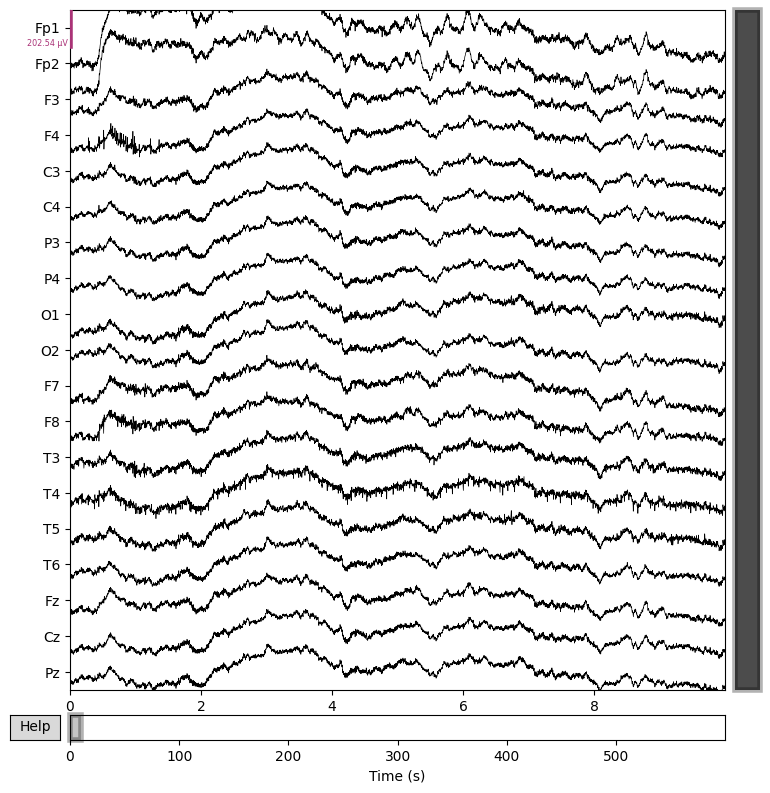

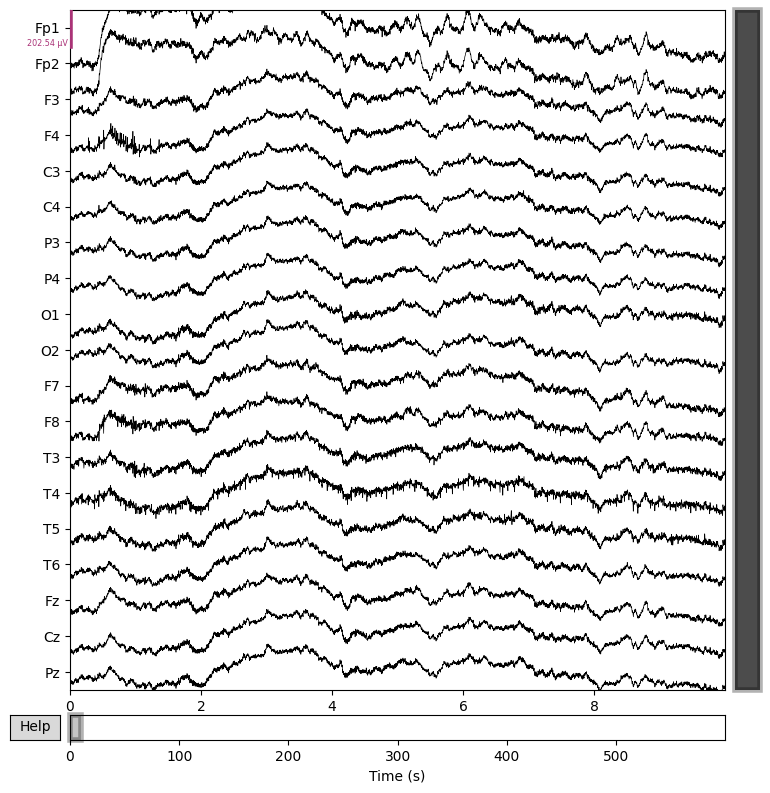

In [22]:
raw.plot(n_channels=20, scalings="auto")


In [24]:
events, event_id = mne.events_from_annotations(raw)

print(events)


[]


In [25]:
epochs = mne.make_fixed_length_epochs(
    raw,
    duration=2.0,   # 2-second windows
    overlap=1.0,
    preload=True
)

epochs


Not setting metadata
598 matching events found
No baseline correction applied
0 projection items activated
Loading data for 598 events and 1000 original time points ...
0 bad epochs dropped


<Epochs | 598 events (all good), 0 – 1.998 s (baseline off), ~86.7 MiB, data loaded,
 '1': 598>

In [26]:
from mne.time_frequency import psd_array_welch
import numpy as np

sfreq = raw.info["sfreq"]
data = epochs.get_data()

bands = {
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30)
}

features = []

for band, (fmin, fmax) in bands.items():
    psd, freqs = psd_array_welch(
        data,
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        verbose=False
    )
    band_power = psd.mean(axis=-1)
    features.append(band_power)

X = np.concatenate(features, axis=1)  # shape: epochs × (channels × bands)


In [27]:
y = np.zeros(len(X))
y[len(X)//2:] = 1


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear"))
])

clf.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(kernel='linear'))])

In [29]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.76
